In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [2]:
from tqdm.autonotebook import tqdm
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
#import tensorflow.compat.v1 as tf
#tf.enable_eager_execution()
#tf.disable_v2_behavior()

In [4]:
import tensorflow as tf

In [5]:
class subnetwork(object):
    """ defines modules within a network (e.g. encoder, decoder, discriminator)
    """
    def __init__(self, params):
        self.__dict__.update(params.__dict__)

In [7]:

class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation="relu"
                ),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation="relu"
                ),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.generative_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7 * 7 * 32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=(2, 2),
                    padding="SAME",
                    activation="relu",
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=(2, 2),
                    padding="SAME",
                    activation="relu",
                ),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=(1, 1), padding="SAME"
                ),
            ]
        )

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(
        -0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi), axis=raxis
    )


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0.0, 0.0)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


def compute_gradients(model, x):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    return tape.gradient(loss, model.trainable_variables), loss


def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))
    
def generate_images(model, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap="gray")
        plt.axis("off")
        
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.show()

In [8]:
epochs = 100
latent_dim = 2
num_examples_to_generate = 16

In [9]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim]
)

In [10]:
optimizer = tf.keras.optimizers.Adam(1e-4)
model = CVAE(latent_dim)

In [11]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32")

# Normalizing the images to the range of [0., 1.]
train_images /= 255.0
test_images /= 255.0

# Binarization
train_images[train_images >= 0.5] = 1.0
train_images[train_images < 0.5] = 0.0
test_images[test_images >= 0.5] = 1.0
test_images[test_images < 0.5] = 0.0

TRAIN_BUF = 60000
BATCH_SIZE = 512
TEST_BUF = 10000
# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)
)
train_dataset = train_dataset.prefetch(buffer_size=4)
test_dataset = test_dataset.prefetch(buffer_size=4)

In [12]:
#@tf.function
def test(model, test_dataset, epoch):
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print(
        "Epoch: {}, Test set ELBO: {}".format(
            epoch, elbo
        )
    )
    generate_images(model, random_vector_for_generation)

In [13]:
#@tf.function
def train(model, train_dataset, optimizer):
    for train_x in tqdm(train_dataset): 
        with tf.GradientTape() as tape:
            loss = compute_loss(model, train_x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))  

In [14]:
train(model, train_dataset, optimizer)

Epoch: 100, Test set ELBO: -153.29531860351562


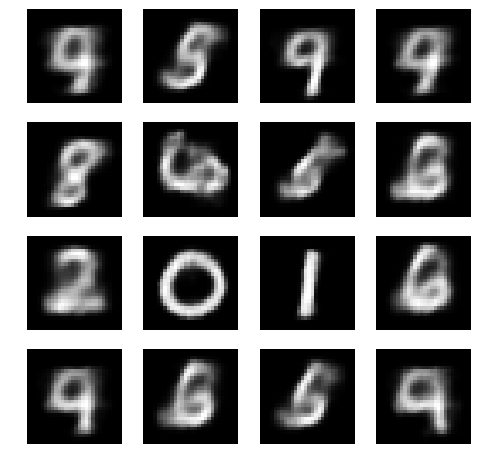

In [15]:
for epoch in range(1, epochs + 1):
    train(model, train_dataset, optimizer)
    if epoch % 1 == 0:
        test(model, test_dataset, epoch)